In [1]:
import csv
import h5py
import requests
import numpy as np
import scipy.integrate
import illustris_python as il
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
from hoki.csp.eventrate import CSPEventRate
from hoki.constants import BPASS_EVENT_TYPES, BPASS_METALLICITIES

In [2]:
# helper function to get subhalo data
def get(path, params=None):
    r = requests.get(path, params=params, headers={"api-key":"ac0fbfe1251d6f93c582c5490527df5d"})
    r.raise_for_status()  # raise exception if the request does not succeed (does not get HTTP code 200)
    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string
    return r

In [3]:
# test with data.h5

In [4]:
data = h5py.File(f"./data.h5", "r")
SFH = data['SFH']['TNG']

In [5]:
event_types = ["Ia", "IIP", "II", "Ib", "Ic", "LGRB", "PISNe"]

In [6]:
@np.vectorize
def calc_LB(z, omega0, omega1, hubble):
    '''
    Calculates the lookback time according to Hobbs.

    Parameters:
    z : float
        The redshift at which you want to calculate the lookback
    omega0 : float
        The Matter density parameter (0.3111 Planck 2018)
    omega1 : float
        The dark energy density parameter (0.6889 Planck 2018)
    hubble : float
        The hubble parameters (0.6766 Planck 2018)
    '''
    def func(x):
        E = np.sqrt(omega0*(1+x)**3 + omega1)
        return 1/((1+x)*E)
    # can be simplified by already doing the extra coefficient calculations
    t_hubble = (1/(100*hubble))*3.0856776*10**19
    return t_hubble *scipy.integrate.quad(func, 0, z)[0]/(60*60*24*365.2388526)

In [7]:
met_indicies = ["Z=0.00001", "Z=0.0001", "Z=0.001", "Z=0.002", "Z=0.003", "Z=0.004", "Z=0.006", "Z=0.008", "Z=0.010", 
                "Z=0.014", "Z=0.020", "Z=0.030", "Z=0.040"]
transient_types = ["Type Ia", "CCSN", "LGRB", "PISN"]

In [8]:
# Briel data

In [9]:
h = 0.6766
omega_M = 0.3111
omega_L = 0.6889
lookback_time = calc_LB(SFH.attrs['redshift'], omega_M, omega_L, h) # lookback time into years

In [10]:
SFH_input = SFH[:].reshape(1, SFH.shape[0], SFH.shape[1])*1e9  #Transform SFR from per Myr^-3 to Gpc^-3$
er_csp = CSPEventRate("./BPASS data/", imf="imf135_300", binary=True)

In [11]:
out, edges = er_csp.grid_over_time(SFH_input, lookback_time, event_types , 100, return_time_edges=True)
out = out[0]
edges = edges[:-1]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


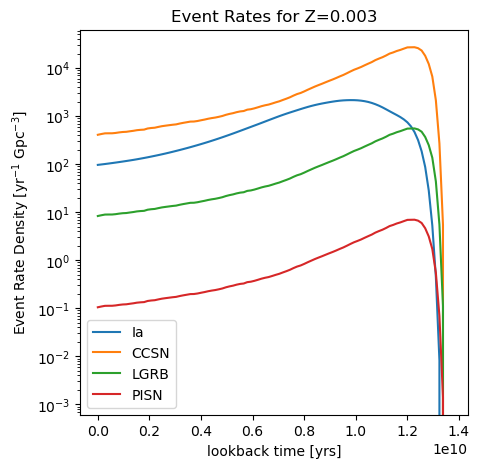

In [12]:
met_index = 4

fig = plt.figure(figsize=(5,5))
plt.plot(edges, out[:,0][met_index], label='Ia')
plt.plot(edges, out[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges, out[:,5][met_index], label='LGRB')
plt.plot(edges, out[:,6][met_index], label='PISN')

plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.title(r"Event Rates for "+met_indicies[met_index])
plt.legend()
plt.show()

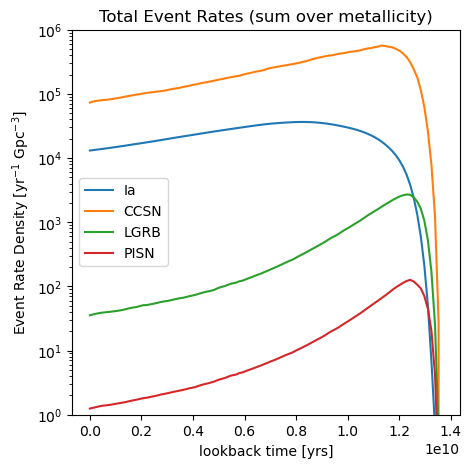

In [13]:
fig = plt.figure(figsize=(5,5))
plt.plot(edges, np.sum(out[:,0], axis=0), label='Ia')
plt.plot(edges, np.sum(out[:,1:5], axis=0).sum(axis=0), label='CCSN')
plt.plot(edges, np.sum(out[:,5], axis=0), label='LGRB')
plt.plot(edges, np.sum(out[:,6], axis=0), label='PISN')

plt.yscale('log')
plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.title(r"Total Event Rates (sum over metallicity)")
plt.legend()
plt.show()

In [14]:
# TNG Data

In [15]:
# TNG cosmology
h = 0.6774
omega_M = 0.3089
omega_L = 0.6911
lookback_time = calc_LB(SFH.attrs['redshift'], omega_M, omega_L, h) # lookback time into years

In [16]:
SFR2 = []
with open('./mass_range2_stellar.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR2.append(row)
SFR2_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR2)):
    SFR2_Z[subhalo] = [float(num) for num in SFR2[subhalo]]

for index in range(len(SFR2_Z)):
    SFR2_Z[index] = np.array(SFR2_Z[index][::-1])
SFR2_Z = np.array([SFR2_Z])

out2, edges2 = er_csp.grid_over_time(SFR2_Z, lookback_time, event_types , 100, return_time_edges=True)
out2 = out2[0]
edges2 = edges2[:-1]

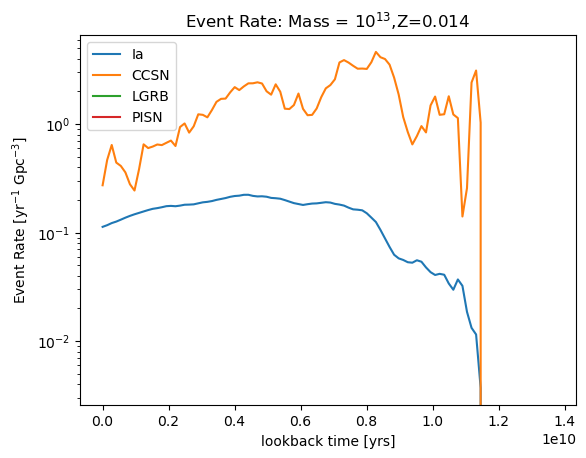

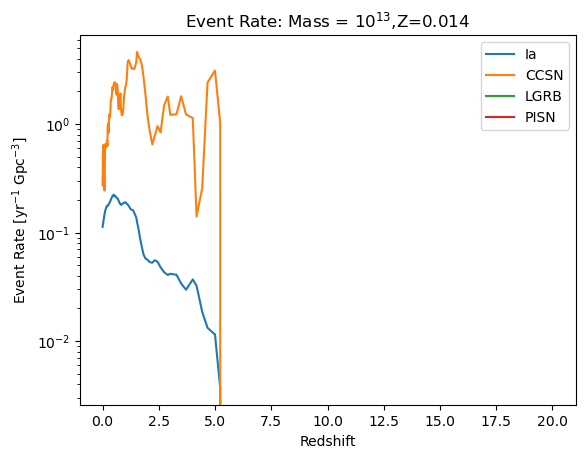

In [42]:
# plotting data for mass2 group

met_index = 9

plt.subplot(1, 1, 1)
plt.plot(edges2, out2[:,0][met_index], label='Ia')
plt.plot(edges2, out2[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges2, out2[:,5][met_index], label='LGRB')
plt.plot(edges2, out2[:,6][met_index], label='PISN')
plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate: Mass = 10$^{13}$,"+met_indicies[met_index])
plt.legend()
plt.show()

plt.subplot(1, 1, 1)
plt.plot(SFH.attrs['redshift'], out2[:,0][met_index], label='Ia')
plt.plot(SFH.attrs['redshift'], out2[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(SFH.attrs['redshift'], out2[:,5][met_index], label='LGRB')
plt.plot(SFH.attrs['redshift'], out2[:,6][met_index], label='PISN')
plt.yscale('log')
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate: Mass = 10$^{13}$,"+met_indicies[met_index])
plt.legend()
plt.show()

In [18]:
SFR3 = []
with open('./mass_range3_stellar.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num) for num in SFR3[subhalo]]

for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index][::-1])
SFR3_Z = np.array([SFR3_Z])

out3, edges3 = er_csp.grid_over_time(SFR3_Z, lookback_time, event_types , 100, return_time_edges=True)
out3 = out3[0]
edges3 = edges3[:-1]

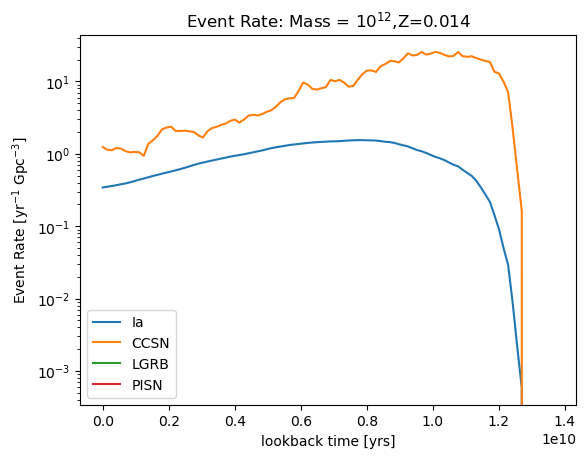

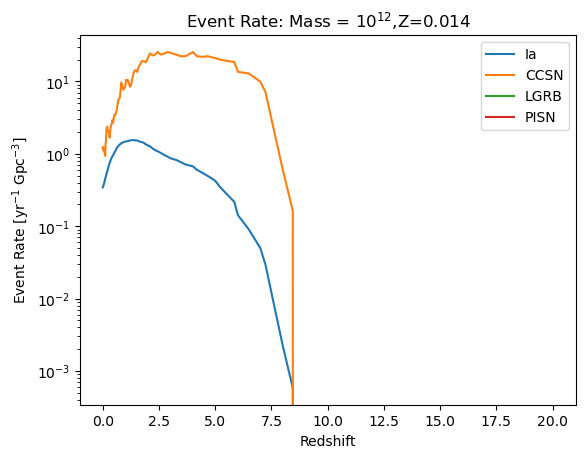

In [41]:
# plotting data for mass3 group

met_index = 9

plt.subplot(1, 1, 1)
plt.plot(edges3, out3[:,0][met_index], label='Ia')
plt.plot(edges3, out3[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges3, out3[:,5][met_index], label='LGRB')
plt.plot(edges3, out3[:,6][met_index], label='PISN')
plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate: Mass = 10$^{12}$,"+met_indicies[met_index])
plt.legend()
plt.show()

plt.subplot(1, 1, 1)
plt.plot(SFH.attrs['redshift'], out3[:,0][met_index], label='Ia')
plt.plot(SFH.attrs['redshift'], out3[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(SFH.attrs['redshift'], out3[:,5][met_index], label='LGRB')
plt.plot(SFH.attrs['redshift'], out3[:,6][met_index], label='PISN')
plt.yscale('log')
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate: Mass = 10$^{12}$,"+met_indicies[met_index])
plt.legend()
plt.show()

In [20]:
SFR4 = []
with open('./mass_range4_stellar.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num) for num in SFR4[subhalo]]

for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index][::-1])
SFR4_Z = np.array([SFR4_Z])

out4, edges4 = er_csp.grid_over_time(SFR4_Z, lookback_time, event_types , 100, return_time_edges=True)
out4 = out4[0]
edges4 = edges4[:-1]

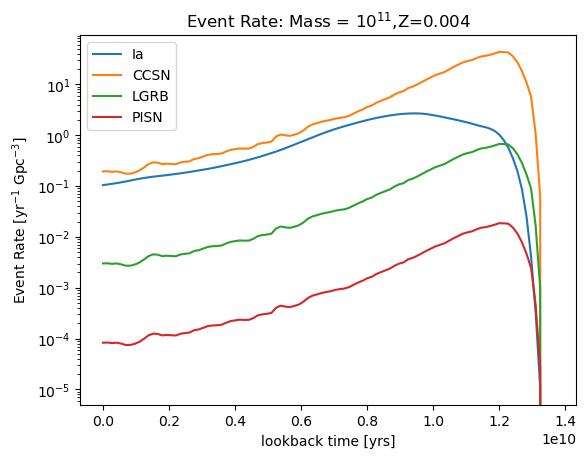

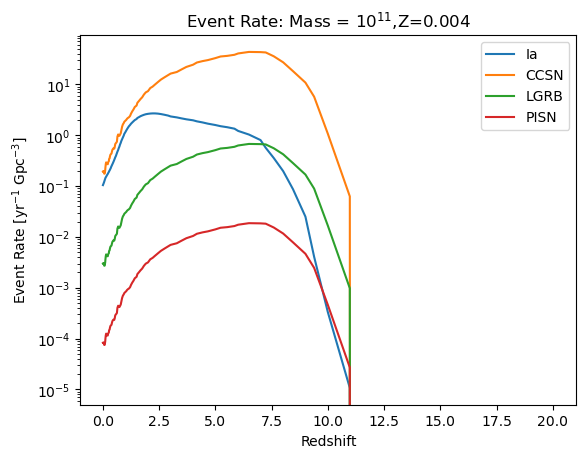

In [21]:
# plotting data for mass4 group

met_index = 5

plt.subplot(1, 1, 1)
plt.plot(edges4, out4[:,0][met_index], label='Ia')
plt.plot(edges4, out4[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges4, out4[:,5][met_index], label='LGRB')
plt.plot(edges4, out4[:,6][met_index], label='PISN')
plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate: Mass = 10$^{11}$,"+met_indicies[met_index])
plt.legend()
plt.show()

plt.subplot(1, 1, 1)
plt.plot(SFH.attrs['redshift'], out4[:,0][met_index], label='Ia')
plt.plot(SFH.attrs['redshift'], out4[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(SFH.attrs['redshift'], out4[:,5][met_index], label='LGRB')
plt.plot(SFH.attrs['redshift'], out4[:,6][met_index], label='PISN')
plt.yscale('log')
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate: Mass = 10$^{11}$,"+met_indicies[met_index])
plt.legend()
plt.show()

In [22]:
SFR5 = []
with open('./mass_range5_stellar.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num) for num in SFR5[subhalo]]

for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index][::-1])
SFR5_Z = np.array([SFR5_Z])

out5, edges5 = er_csp.grid_over_time(SFR5_Z, lookback_time, event_types , 100, return_time_edges=True)
out5 = out5[0]
edges5 = edges5[:-1]

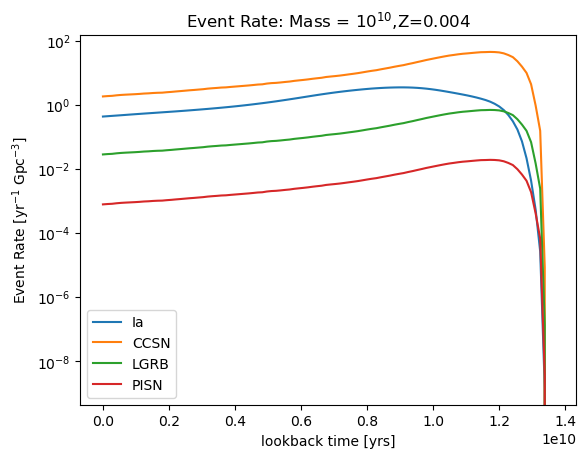

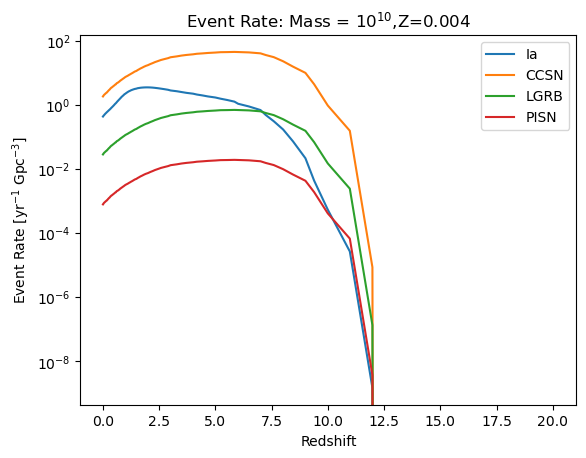

In [23]:
# plotting data for mass5 group

met_index = 5

plt.subplot(1, 1, 1)
plt.plot(edges5, out5[:,0][met_index], label='Ia')
plt.plot(edges5, out5[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges5, out5[:,5][met_index], label='LGRB')
plt.plot(edges5, out5[:,6][met_index], label='PISN')
plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate: Mass = 10$^{10}$,"+met_indicies[met_index])
plt.legend()
plt.show()

plt.subplot(1, 1, 1)
plt.plot(SFH.attrs['redshift'], out5[:,0][met_index], label='Ia')
plt.plot(SFH.attrs['redshift'], out5[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(SFH.attrs['redshift'], out5[:,5][met_index], label='LGRB')
plt.plot(SFH.attrs['redshift'], out5[:,6][met_index], label='PISN')
plt.yscale('log')
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate: Mass = 10$^{10}$,"+met_indicies[met_index])
plt.legend()
plt.show()

In [24]:
SFR6 = []
with open('./mass_range6_stellar.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR6.append(row)
SFR6_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR6)):
    SFR6_Z[subhalo] = [float(num) for num in SFR6[subhalo]]

for index in range(len(SFR6_Z)):
    SFR6_Z[index] = np.array(SFR6_Z[index][::-1])
SFR6_Z = np.array([SFR6_Z])

out6, edges6 = er_csp.grid_over_time(SFR6_Z, lookback_time, event_types , 100, return_time_edges=True)
out6 = out6[0]
edges6 = edges6[:-1]

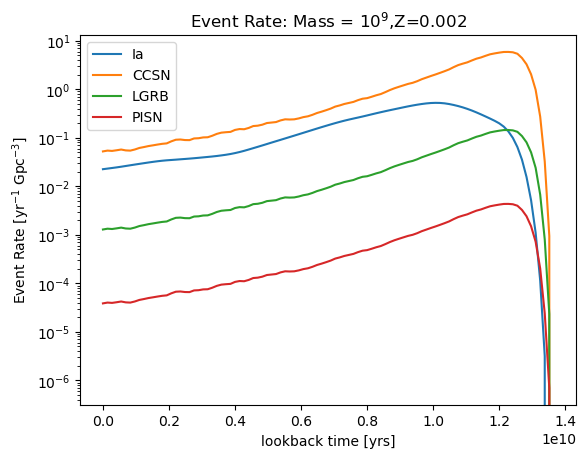

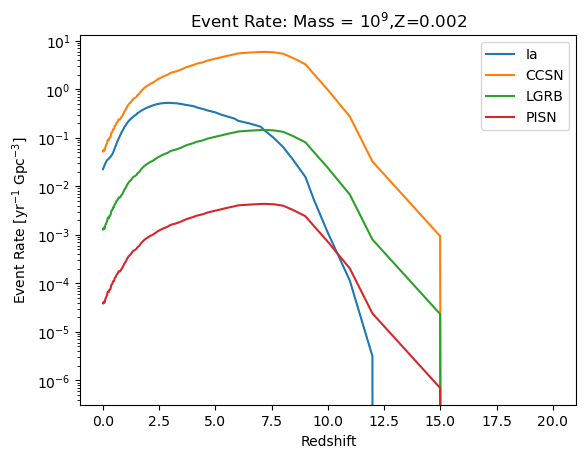

In [25]:
# plotting data for mass6 group

met_index = 3

plt.subplot(1, 1, 1)
plt.plot(edges6, out6[:,0][met_index], label='Ia')
plt.plot(edges6, out6[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges6, out6[:,5][met_index], label='LGRB')
plt.plot(edges6, out6[:,6][met_index], label='PISN')
plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate: Mass = 10$^{9}$,"+met_indicies[met_index])
plt.legend()
plt.show()

plt.subplot(1, 1, 1)
plt.plot(SFH.attrs['redshift'], out6[:,0][met_index], label='Ia')
plt.plot(SFH.attrs['redshift'], out6[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(SFH.attrs['redshift'], out6[:,5][met_index], label='LGRB')
plt.plot(SFH.attrs['redshift'], out6[:,6][met_index], label='PISN')
plt.yscale('log')
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate: Mass = 10$^{9}$,"+met_indicies[met_index])
plt.legend()
plt.show()

In [26]:
SFR7 = []
with open('./mass_range7_stellar.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR7.append(row)
SFR7_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR7)):
    SFR7_Z[subhalo] = [float(num) for num in SFR7[subhalo]]

for index in range(len(SFR7_Z)):
    SFR7_Z[index] = np.array(SFR7_Z[index][::-1])
SFR7_Z = np.array([SFR7_Z])

out7, edges7 = er_csp.grid_over_time(SFR7_Z, lookback_time, event_types , 100, return_time_edges=True)
out7 = out7[0]
edges7 = edges7[:-1]

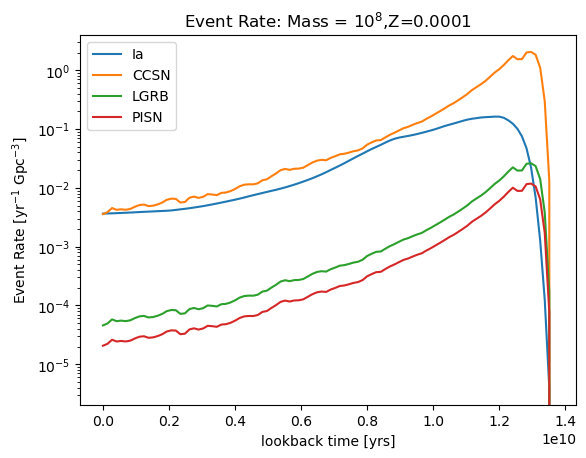

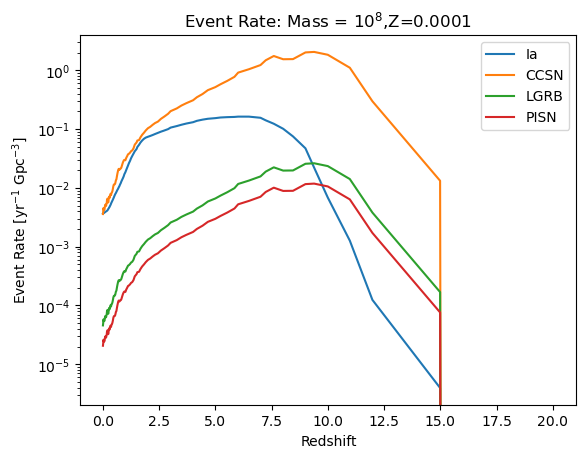

In [27]:
# plotting data for mass7 group

met_index = 1

plt.subplot(1, 1, 1)
plt.plot(edges7, out7[:,0][met_index], label='Ia')
plt.plot(edges7, out7[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges7, out7[:,5][met_index], label='LGRB')
plt.plot(edges7, out7[:,6][met_index], label='PISN')
plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate: Mass = 10$^{8}$,"+met_indicies[met_index])
plt.legend()
plt.show()

plt.subplot(1, 1, 1)
plt.plot(SFH.attrs['redshift'], out7[:,0][met_index], label='Ia')
plt.plot(SFH.attrs['redshift'], out7[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(SFH.attrs['redshift'], out7[:,5][met_index], label='LGRB')
plt.plot(SFH.attrs['redshift'], out7[:,6][met_index], label='PISN')
plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate: Mass = 10$^{8}$,"+met_indicies[met_index])
plt.legend()
plt.show()

In [28]:
# Comparing transient event rates between masses

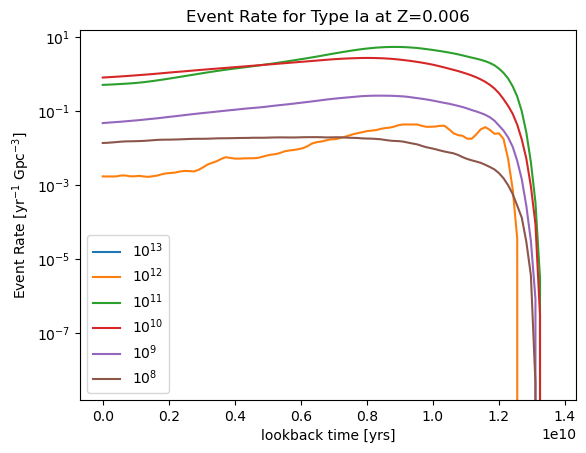

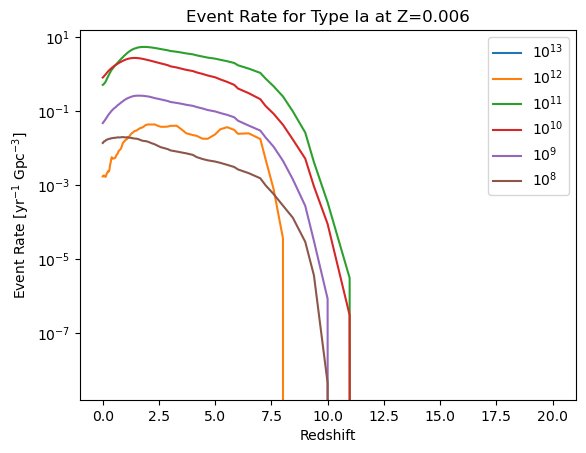

In [29]:
met_index = 6
transient_type = 0

plt.subplot(1, 1, 1)
plt.plot(edges2, out2[:,transient_type][met_index], label='10$^{13}$')
plt.plot(edges3, out3[:,transient_type][met_index], label='10$^{12}$')
plt.plot(edges4, out4[:,transient_type][met_index], label='10$^{11}$')
plt.plot(edges5, out5[:,transient_type][met_index], label='10$^{10}$')
plt.plot(edges6, out6[:,transient_type][met_index], label='10$^{9}$')
plt.plot(edges7, out7[:,transient_type][met_index], label='10$^{8}$')
plt.yscale('log')
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate for "+transient_types[transient_type]+" at "+met_indicies[met_index])
plt.legend()
plt.show()

plt.subplot(1, 1, 1)
plt.plot(SFH.attrs['redshift'], out2[:,transient_type][met_index], label='10$^{13}$')
plt.plot(SFH.attrs['redshift'], out3[:,transient_type][met_index], label='10$^{12}$')
plt.plot(SFH.attrs['redshift'], out4[:,transient_type][met_index], label='10$^{11}$')
plt.plot(SFH.attrs['redshift'], out5[:,transient_type][met_index], label='10$^{10}$')
plt.plot(SFH.attrs['redshift'], out6[:,transient_type][met_index], label='10$^{9}$')
plt.plot(SFH.attrs['redshift'], out7[:,transient_type][met_index], label='10$^{8}$')
plt.yscale('log')
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate for "+transient_types[transient_type]+" at "+met_indicies[met_index])
plt.legend()
plt.show()

In [30]:
type_Ia_2 = [sum(x) for x in zip(out2[:,0][0], out2[:,0][1], out2[:,0][2], out2[:,0][3], out2[:,0][4], out2[:,0][5], out2[:,0][6], out2[:,0][7], 
                                out2[:,0][8], out2[:,0][9], out2[:,0][10], out2[:,0][11], out2[:,0][12])]
type_Ia_3 = [sum(x) for x in zip(out3[:,0][0], out3[:,0][1], out3[:,0][2], out3[:,0][3], out3[:,0][4], out3[:,0][5], out3[:,0][6], out3[:,0][7], 
                                out3[:,0][8], out3[:,0][9], out3[:,0][10], out3[:,0][11], out3[:,0][12])]
type_Ia_4 = [sum(x) for x in zip(out4[:,0][0], out4[:,0][1], out4[:,0][2], out4[:,0][3], out4[:,0][4], out4[:,0][5], out4[:,0][6], out4[:,0][7], 
                                out4[:,0][8], out4[:,0][9], out4[:,0][10], out4[:,0][11], out4[:,0][12])]
type_Ia_5 = [sum(x) for x in zip(out5[:,0][0], out5[:,0][1], out5[:,0][2], out5[:,0][3], out5[:,0][4], out5[:,0][5], out5[:,0][6], out5[:,0][7], 
                                out5[:,0][8], out5[:,0][9], out5[:,0][10], out5[:,0][11], out5[:,0][12])]
type_Ia_6 = [sum(x) for x in zip(out6[:,0][0], out6[:,0][1], out6[:,0][2], out6[:,0][3], out6[:,0][4], out6[:,0][5], out6[:,0][6], out6[:,0][7], 
                                out6[:,0][8], out6[:,0][9], out6[:,0][10], out6[:,0][11], out6[:,0][12])]
type_Ia_7 = [sum(x) for x in zip(out7[:,0][0], out7[:,0][1], out7[:,0][2], out7[:,0][3], out7[:,0][4], out7[:,0][5], out7[:,0][6], out7[:,0][7], 
                                out7[:,0][8], out7[:,0][9], out7[:,0][10], out7[:,0][11], out7[:,0][12])]
type_Ia = [sum(x) for x in zip(type_Ia_2, type_Ia_3, type_Ia_4, type_Ia_5, type_Ia_6, type_Ia_7)]

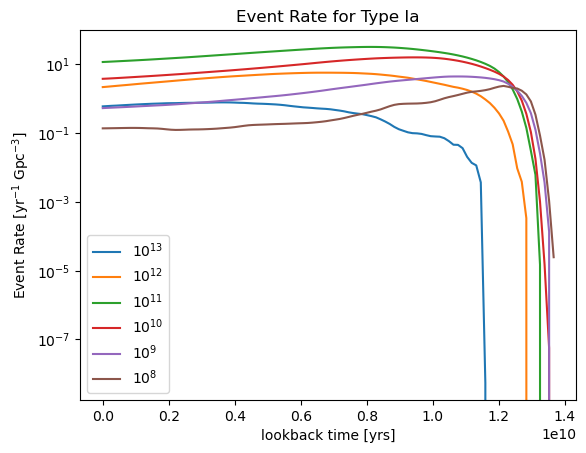

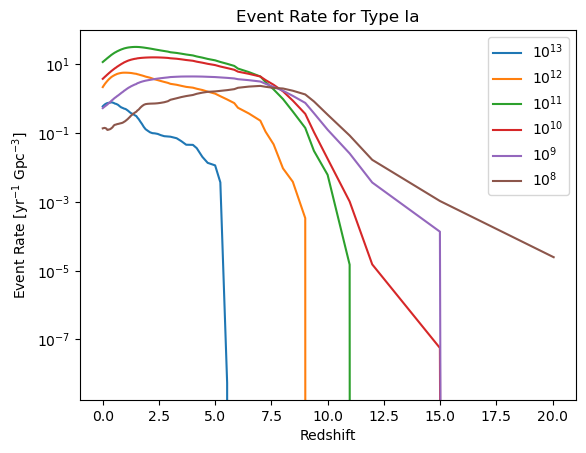

In [31]:
plt.subplot(1, 1, 1)
plt.plot(edges2, type_Ia_2, label='10$^{13}$')
plt.plot(edges3, type_Ia_3, label='10$^{12}$')
plt.plot(edges4, type_Ia_4, label='10$^{11}$')
plt.plot(edges5, type_Ia_5, label='10$^{10}$')
plt.plot(edges6, type_Ia_6, label='10$^{9}$')
plt.plot(edges7, type_Ia_7, label='10$^{8}$')
plt.yscale('log')
#plt.ylim(0.01,100)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate for Type Ia")
plt.legend()
plt.show()

plt.subplot(1, 1, 1)
plt.plot(SFH.attrs['redshift'], type_Ia_2, label='10$^{13}$')
plt.plot(SFH.attrs['redshift'], type_Ia_3, label='10$^{12}$')
plt.plot(SFH.attrs['redshift'], type_Ia_4, label='10$^{11}$')
plt.plot(SFH.attrs['redshift'], type_Ia_5, label='10$^{10}$')
plt.plot(SFH.attrs['redshift'], type_Ia_6, label='10$^{9}$')
plt.plot(SFH.attrs['redshift'], type_Ia_7, label='10$^{8}$')
plt.yscale('log')
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate for Type Ia")
plt.legend()
plt.show()

In [32]:
CCSN_2 = [sum(x) for x in zip(out2[:,1:5][0].sum(axis=0), out2[:,1:5][1].sum(axis=0), out2[:,1:5][2].sum(axis=0), out2[:,1:5][3].sum(axis=0), 
                              out2[:,1:5][4].sum(axis=0), out2[:,1:5][5].sum(axis=0), out2[:,1:5][6].sum(axis=0), out2[:,1:5][7].sum(axis=0),
                              out2[:,1:5][8].sum(axis=0), out2[:,1:5][9].sum(axis=0), out2[:,1:5][10].sum(axis=0), out2[:,1:5][11].sum(axis=0),
                              out2[:,1:5][12].sum(axis=0))]
CCSN_3 = [sum(x) for x in zip(out3[:,1:5][0].sum(axis=0), out3[:,1:5][1].sum(axis=0), out3[:,1:5][2].sum(axis=0), out3[:,1:5][3].sum(axis=0),
                              out3[:,1:5][4].sum(axis=0), out3[:,1:5][5].sum(axis=0), out3[:,1:5][6].sum(axis=0), out3[:,1:5][7].sum(axis=0),
                              out3[:,1:5][8].sum(axis=0), out3[:,1:5][9].sum(axis=0), out3[:,1:5][10].sum(axis=0), out3[:,1:5][11].sum(axis=0),
                              out3[:,1:5][12].sum(axis=0))]
CCSN_4 = [sum(x) for x in zip(out4[:,1:5][0].sum(axis=0), out4[:,1:5][1].sum(axis=0), out4[:,1:5][2].sum(axis=0), out4[:,1:5][3].sum(axis=0),
                              out4[:,1:5][4].sum(axis=0), out4[:,1:5][5].sum(axis=0), out4[:,1:5][6].sum(axis=0), out4[:,1:5][7].sum(axis=0),
                              out4[:,1:5][8].sum(axis=0), out4[:,1:5][9].sum(axis=0), out4[:,1:5][10].sum(axis=0), out4[:,1:5][11].sum(axis=0),
                              out4[:,1:5][12].sum(axis=0))]
CCSN_5 = [sum(x) for x in zip(out5[:,1:5][0].sum(axis=0), out5[:,1:5][1].sum(axis=0), out5[:,1:5][2].sum(axis=0), out5[:,1:5][3].sum(axis=0),
                              out5[:,1:5][4].sum(axis=0), out5[:,1:5][5].sum(axis=0), out5[:,1:5][6].sum(axis=0), out5[:,1:5][7].sum(axis=0),
                              out5[:,1:5][8].sum(axis=0), out5[:,1:5][9].sum(axis=0), out5[:,1:5][10].sum(axis=0), out5[:,1:5][11].sum(axis=0),
                              out5[:,1:5][12].sum(axis=0))]
CCSN_6 = [sum(x) for x in zip(out6[:,1:5][0].sum(axis=0), out6[:,1:5][1].sum(axis=0), out6[:,1:5][2].sum(axis=0), out6[:,1:5][3].sum(axis=0),
                              out6[:,1:5][4].sum(axis=0), out6[:,1:5][5].sum(axis=0), out6[:,1:5][6].sum(axis=0), out6[:,1:5][7].sum(axis=0),
                              out6[:,1:5][8].sum(axis=0), out6[:,1:5][9].sum(axis=0), out6[:,1:5][10].sum(axis=0), out6[:,1:5][11].sum(axis=0),
                              out6[:,1:5][12].sum(axis=0))]
CCSN_7 = [sum(x) for x in zip(out7[:,1:5][0].sum(axis=0), out7[:,1:5][1].sum(axis=0), out7[:,1:5][2].sum(axis=0), out7[:,1:5][3].sum(axis=0),
                              out7[:,1:5][4].sum(axis=0), out7[:,1:5][5].sum(axis=0), out7[:,1:5][6].sum(axis=0), out7[:,1:5][7].sum(axis=0),
                              out7[:,1:5][8].sum(axis=0), out7[:,1:5][9].sum(axis=0), out7[:,1:5][10].sum(axis=0), out7[:,1:5][11].sum(axis=0),
                              out7[:,1:5][12].sum(axis=0))]
CCSN = [sum(x) for x in zip(CCSN_2, CCSN_3, CCSN_4, CCSN_5, CCSN_6, CCSN_7)]

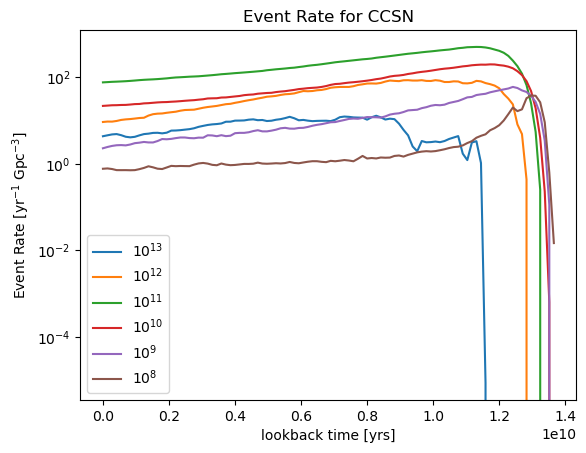

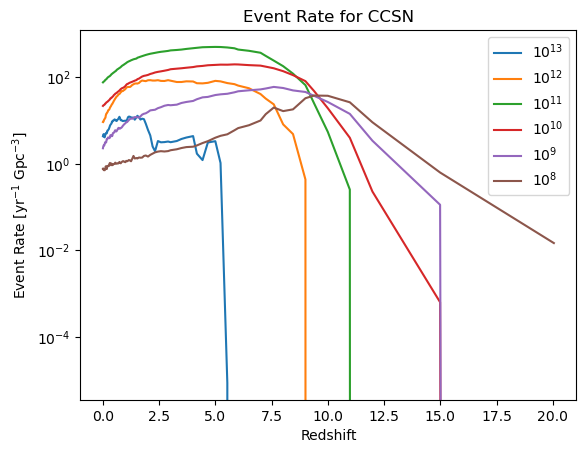

In [33]:
plt.subplot(1, 1, 1)
plt.plot(edges2, CCSN_2, label='10$^{13}$')
plt.plot(edges3, CCSN_3, label='10$^{12}$')
plt.plot(edges4, CCSN_4, label='10$^{11}$')
plt.plot(edges5, CCSN_5, label='10$^{10}$')
plt.plot(edges6, CCSN_6, label='10$^{9}$')
plt.plot(edges7, CCSN_7, label='10$^{8}$')
plt.yscale('log')
#plt.xlim(0,5)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate for CCSN")
plt.legend()
plt.show()

plt.subplot(1, 1, 1)
plt.plot(SFH.attrs['redshift'], CCSN_2, label='10$^{13}$')
plt.plot(SFH.attrs['redshift'], CCSN_3, label='10$^{12}$')
plt.plot(SFH.attrs['redshift'], CCSN_4, label='10$^{11}$')
plt.plot(SFH.attrs['redshift'], CCSN_5, label='10$^{10}$')
plt.plot(SFH.attrs['redshift'], CCSN_6, label='10$^{9}$')
plt.plot(SFH.attrs['redshift'], CCSN_7, label='10$^{8}$')
plt.yscale('log')
#plt.xlim(0,5)
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate for CCSN")
plt.legend()
plt.show()

In [34]:
LGRB_2 = [sum(x) for x in zip(out2[:,5][0], out2[:,5][1], out2[:,5][2], out2[:,5][3], out2[:,5][4], out2[:,5][5], out2[:,5][6], out2[:,5][7], 
                                out2[:,5][8], out2[:,5][9], out2[:,5][10], out2[:,5][11], out2[:,5][12])]
LGRB_3 = [sum(x) for x in zip(out3[:,5][0], out3[:,5][1], out3[:,5][2], out3[:,5][3], out3[:,5][4], out3[:,5][5], out3[:,5][6], out3[:,5][7], 
                                out3[:,5][8], out3[:,5][9], out3[:,5][10], out3[:,5][11], out3[:,5][12])]
LGRB_4 = [sum(x) for x in zip(out4[:,5][0], out4[:,5][1], out4[:,5][2], out4[:,5][3], out4[:,5][4], out4[:,5][5], out4[:,5][6], out4[:,5][7], 
                                out4[:,5][8], out4[:,5][9], out4[:,5][10], out4[:,5][11], out4[:,5][12])]
LGRB_5 = [sum(x) for x in zip(out5[:,5][0], out5[:,5][1], out5[:,5][2], out5[:,5][3], out5[:,5][4], out5[:,5][5], out5[:,5][6], out5[:,5][7], 
                                out5[:,5][8], out5[:,5][9], out5[:,5][10], out5[:,5][11], out5[:,5][12])]
LGRB_6 = [sum(x) for x in zip(out6[:,5][0], out6[:,5][1], out6[:,5][2], out6[:,5][3], out6[:,5][4], out6[:,5][5], out6[:,5][6], out6[:,5][7], 
                                out6[:,5][8], out6[:,5][9], out6[:,5][10], out6[:,5][11], out6[:,5][12])]
LGRB_7 = [sum(x) for x in zip(out7[:,5][0], out7[:,5][1], out7[:,5][2], out7[:,5][3], out7[:,5][4], out7[:,5][5], out7[:,5][6], out7[:,5][7], 
                                out7[:,5][8], out7[:,5][9], out7[:,5][10], out7[:,5][11], out7[:,5][12])]
LGRB = [sum(x) for x in zip(LGRB_2, LGRB_3, LGRB_4, LGRB_5, LGRB_6, LGRB_7)]

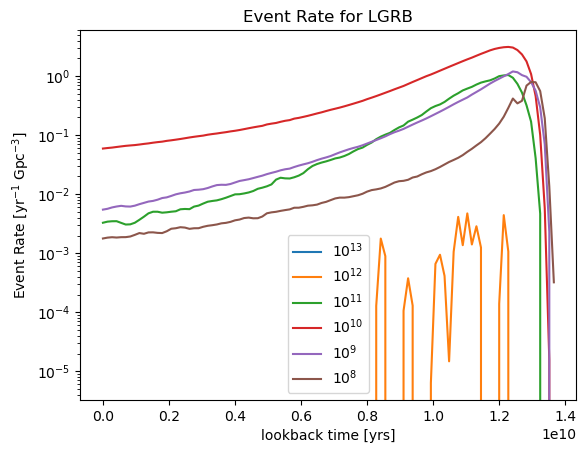

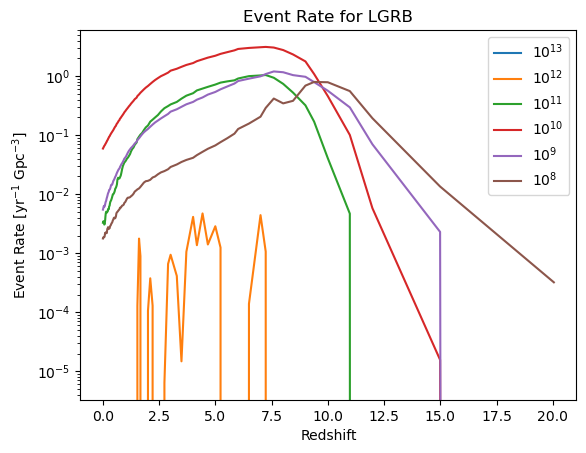

In [35]:
plt.subplot(1, 1, 1)
plt.plot(edges2, LGRB_2, label='10$^{13}$')
plt.plot(edges3, LGRB_3, label='10$^{12}$')
plt.plot(edges4, LGRB_4, label='10$^{11}$')
plt.plot(edges5, LGRB_5, label='10$^{10}$')
plt.plot(edges6, LGRB_6, label='10$^{9}$')
plt.plot(edges7, LGRB_7, label='10$^{8}$')
plt.yscale('log')
#plt.xlim(0,5)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate for LGRB")
plt.legend()
plt.show()

plt.subplot(1, 1, 1)
plt.plot(SFH.attrs['redshift'], LGRB_2, label='10$^{13}$')
plt.plot(SFH.attrs['redshift'], LGRB_3, label='10$^{12}$')
plt.plot(SFH.attrs['redshift'], LGRB_4, label='10$^{11}$')
plt.plot(SFH.attrs['redshift'], LGRB_5, label='10$^{10}$')
plt.plot(SFH.attrs['redshift'], LGRB_6, label='10$^{9}$')
plt.plot(SFH.attrs['redshift'], LGRB_7, label='10$^{8}$')
plt.yscale('log')
#plt.xlim(0,5)
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate for LGRB")
plt.legend()
plt.show()

In [36]:
PISN_2 = [sum(x) for x in zip(out2[:,6][0], out2[:,6][1], out2[:,6][2], out2[:,6][3], out2[:,6][4], out2[:,6][5], out2[:,6][6], out2[:,6][7], 
                                out2[:,6][8], out2[:,6][9], out2[:,6][10], out2[:,6][11], out2[:,6][12])]
PISN_3 = [sum(x) for x in zip(out3[:,6][0], out3[:,6][1], out3[:,6][2], out3[:,6][3], out3[:,6][4], out3[:,6][5], out3[:,6][6], out3[:,6][7], 
                                out3[:,6][8], out3[:,6][9], out3[:,6][10], out3[:,6][11], out3[:,6][12])]
PISN_4 = [sum(x) for x in zip(out4[:,6][0], out4[:,6][1], out4[:,6][2], out4[:,6][3], out4[:,6][4], out4[:,6][5], out4[:,6][6], out4[:,6][7], 
                                out4[:,6][8], out4[:,6][9], out4[:,6][10], out4[:,6][11], out4[:,6][12])]
PISN_5 = [sum(x) for x in zip(out5[:,6][0], out5[:,6][1], out5[:,6][2], out5[:,6][3], out5[:,6][4], out5[:,6][5], out5[:,6][6], out5[:,6][7], 
                                out5[:,6][8], out5[:,6][9], out5[:,6][10], out5[:,6][11], out5[:,6][12])]
PISN_6 = [sum(x) for x in zip(out6[:,6][0], out6[:,6][1], out6[:,6][2], out6[:,6][3], out6[:,6][4], out6[:,6][5], out6[:,6][6], out6[:,6][7], 
                                out6[:,6][8], out6[:,6][9], out6[:,6][10], out6[:,6][11], out6[:,6][12])]
PISN_7 = [sum(x) for x in zip(out7[:,6][0], out7[:,6][1], out7[:,6][2], out7[:,6][3], out7[:,6][4], out7[:,6][5], out7[:,6][6], out7[:,6][7], 
                                out7[:,6][8], out7[:,6][9], out7[:,6][10], out7[:,6][11], out7[:,6][12])]
PISN = [sum(x) for x in zip(PISN_2, PISN_3, PISN_4, PISN_5, PISN_6, PISN_7)]

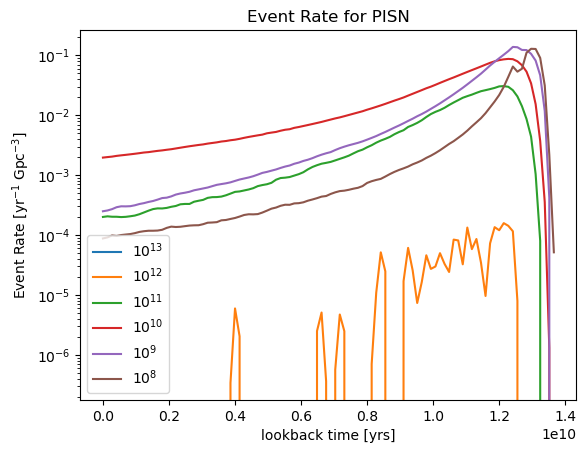

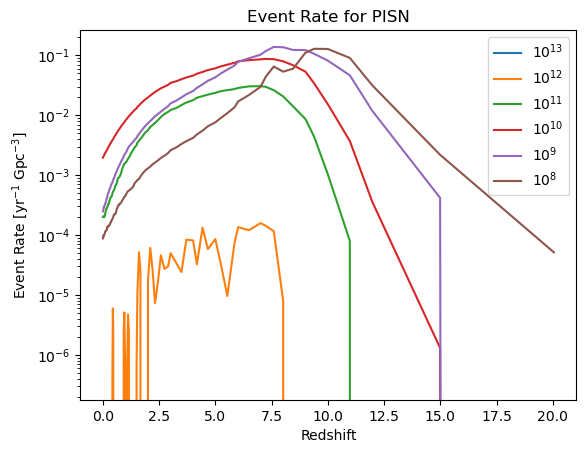

In [37]:
plt.subplot(1, 1, 1)
plt.plot(edges2, PISN_2, label='10$^{13}$')
plt.plot(edges3, PISN_3, label='10$^{12}$')
plt.plot(edges4, PISN_4, label='10$^{11}$')
plt.plot(edges5, PISN_5, label='10$^{10}$')
plt.plot(edges6, PISN_6, label='10$^{9}$')
plt.plot(edges7, PISN_7, label='10$^{8}$')
plt.yscale('log')
#plt.xlim(0,5)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate for PISN")
plt.legend()
plt.show()

plt.subplot(1, 1, 1)
plt.plot(SFH.attrs['redshift'], PISN_2, label='10$^{13}$')
plt.plot(SFH.attrs['redshift'], PISN_3, label='10$^{12}$')
plt.plot(SFH.attrs['redshift'], PISN_4, label='10$^{11}$')
plt.plot(SFH.attrs['redshift'], PISN_5, label='10$^{10}$')
plt.plot(SFH.attrs['redshift'], PISN_6, label='10$^{9}$')
plt.plot(SFH.attrs['redshift'], PISN_7, label='10$^{8}$')
plt.yscale('log')
#plt.xlim(0,5)
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Event Rate for PISN")
plt.legend()
plt.show()

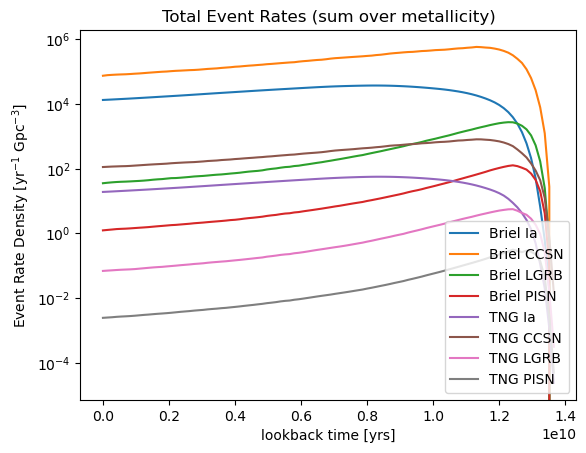

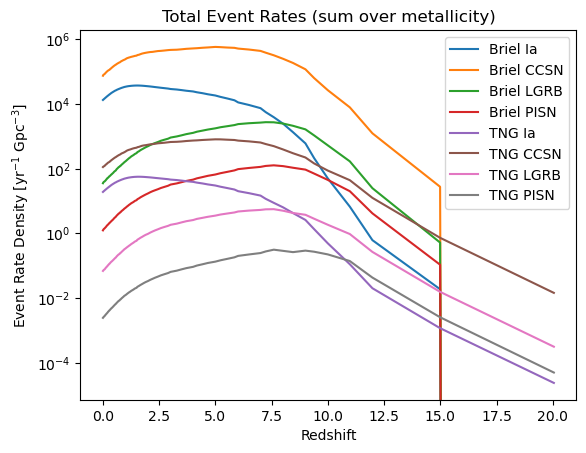

In [38]:
plt.subplot(1, 1, 1)
plt.plot(edges, np.sum(out[:,0], axis=0), label='Briel Ia')
plt.plot(edges, np.sum(out[:,1:5], axis=0).sum(axis=0), label='Briel CCSN')
plt.plot(edges, np.sum(out[:,5], axis=0), label='Briel LGRB')
plt.plot(edges, np.sum(out[:,6], axis=0), label='Briel PISN')
plt.plot(edges, type_Ia, label='TNG Ia')
plt.plot(edges, CCSN, label='TNG CCSN')
plt.plot(edges, LGRB, label='TNG LGRB')
plt.plot(edges, PISN, label='TNG PISN')
plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Total Event Rates (sum over metallicity)")
plt.legend()
plt.show()

plt.subplot(1, 1, 1)
plt.plot(SFH.attrs['redshift'], np.sum(out[:,0], axis=0), label='Briel Ia')
plt.plot(SFH.attrs['redshift'], np.sum(out[:,1:5], axis=0).sum(axis=0), label='Briel CCSN')
plt.plot(SFH.attrs['redshift'], np.sum(out[:,5], axis=0), label='Briel LGRB')
plt.plot(SFH.attrs['redshift'], np.sum(out[:,6], axis=0), label='Briel PISN')
plt.plot(SFH.attrs['redshift'], type_Ia, label='TNG Ia')
plt.plot(SFH.attrs['redshift'], CCSN, label='TNG CCSN')
plt.plot(SFH.attrs['redshift'], LGRB, label='TNG LGRB')
plt.plot(SFH.attrs['redshift'], PISN, label='TNG PISN')
plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}$]")
plt.title(r"Total Event Rates (sum over metallicity)")
plt.legend()
plt.show()